In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns; 
import xgboost as xgb
from sklearn import metrics
sns.set(style="ticks", color_codes=True)
%matplotlib inline
import time
import itertools

In [2]:
# Normalize the data frame values such that the std of each colum will be approximately 1
def norm_fun(df):
    for k in df.columns.values:
        col_mean=df[k].mean()
        col_len=len(df)
        Denom=np.sqrt(1/col_len*np.sum((df[k]-col_mean)**2))
        df[k] = df[k].apply(lambda x: x/Denom)
    return df

In [3]:
d_test=pd.read_pickle('d_test.pkl')
d_test.reset_index(inplace=True,drop=True)

d_train=pd.read_pickle('d_train.pkl')
d_train.reset_index(inplace=True,drop=True)

d_train['y_train10']=np.log10(d_train.y_train)

X=d_train.iloc[:,0:6]
X_train=norm_fun(X)
y_train=d_train['y_train']
d_train.iloc[:,0:6]=X_train

X_test=d_test.iloc[:,0:6]
X_test=norm_fun(X_test)
y_test=d_test['y_test']

In [4]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,gamma=0,learning_rate=0.07,max_depth=3,min_child_weight=1.5,
                 n_estimators=400,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42, n_jobs=-1)#,importance_type='weight')
def apply_xgboost(X_train,y_train,X_test,y_test):
    xgb_model.fit(X_train,y_train)
    y_predicted=xgb_model.predict(X_test)
#     print("r2=",metrics.r2_score(y_test, y_predicted))
#     print("MAE=",metrics.mean_absolute_error(y_test.values,y_predicted))
#     print("RSS=",np.sum((y_test.values-y_predicted)**2))
    return metrics.r2_score(y_test, y_predicted),metrics.mean_absolute_error(y_test.values,y_predicted),np.sum((y_test.values-y_predicted)**2)

In [5]:
start_time = time.time()
R2,MAE,RSS=apply_xgboost(X_train,y_train,X_test,y_test)
print("--- %s seconds ---" % (time.time() - start_time))

r2= 0.7644207275260257
MAE= 7.669625062093264
RSS 44769051.12296998
--- 97.182856798172 seconds ---


In [6]:
# list(itertools.permutations(np.arange(0,6).tolist()))
start_time = time.time()
R2_buf=[]
MAE_buf=[]
RSS_buf=[]
for k in np.arange(1,7):
    buf=np.asarray(list(itertools.combinations(np.arange(0,6), k)))
    for item in buf:
        X_tr_comb=X_train.iloc[:,item]
        X_ts_comb=X_test.iloc[:,item]
        R2,MAE,RSS=apply_xgboost(X_tr_comb,y_train,X_ts_comb,y_test)
        R2_buf.append(R2)
        MAE_buf.append(MAE)
        RSS_buf.append(RSS)
print("--- %s seconds ---" % (time.time() - start_time))       

r2= 0.570396761835348
MAE= 11.679306036261671
RSS 81641008.26871991
r2= 0.17768062159256504
MAE= 19.11079548383068
RSS 156272060.37576354
r2= 0.256620904785025
MAE= 17.662039279423727
RSS 141270394.32598236
r2= 0.00546336412775017
MAE= 20.819567215881644
RSS 188999910.84720832
r2= 0.20243971875208666
MAE= 18.4192915440699
RSS 151566887.14531448
r2= 0.0819620196480656
MAE= 20.208725852306888
RSS 174462247.22399706
r2= 0.7040870213340602
MAE= 9.133017685958324
RSS 56234757.54349032
r2= 0.7051498553126574
MAE= 9.289924463319771
RSS 56032778.53140085
r2= 0.6131767722709696
MAE= 11.121751215212207
RSS 73511173.8646973
r2= 0.674983019675581
MAE= 9.911796368622626
RSS 61765628.423802584
r2= 0.5813252646745921
MAE= 11.536121571688694
RSS 79564175.71393012
r2= 0.28950829996862015
MAE= 17.35548941304536
RSS 135020534.3072562
r2= 0.17166548369490586
MAE= 18.808807282052097
RSS 157415166.10499007
r2= 0.26596266428537896
MAE= 17.737685194771448
RSS 139495103.5533358
r2= 0.23066320688916087
MAE= 18.

In [64]:
ls=[]
for k in np.arange(1,7):
    ls.extend(list(itertools.combinations(np.arange(0,6), k)))
idx=MAE_buf.index(min(MAE_buf))
ls[idx]
X_train.columns.values[list(ls[idx])]

array(['Delta_T', 'FirstPass_Temp', 'T', 'U', 'FH'], dtype=object)

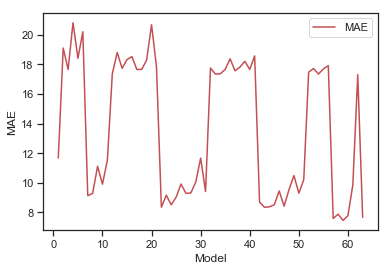

In [61]:
plt.plot(np.arange(1,len(ls)+1), MAE_buf, 'r-',
         label='MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend()
plt.show()

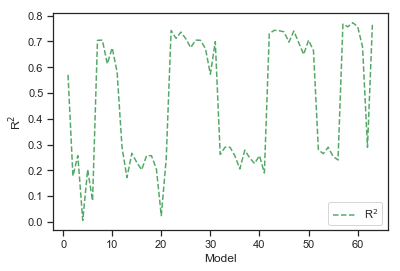

In [62]:
plt.plot(np.arange(1,len(ls)+1), R2_buf, 'g--',
         label='R$^2$')

plt.xlabel('Model')
plt.ylabel('R$^2$')
plt.legend()
plt.show()

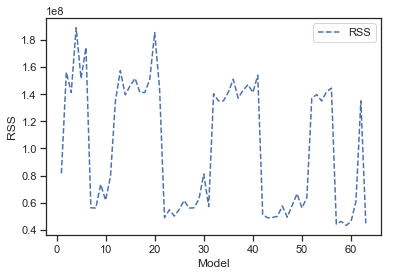

In [63]:

plt.plot(np.arange(1,len(ls)+1), RSS_buf, 'b--',
         label='RSS')


plt.xlabel('Model')
plt.ylabel('RSS')
plt.legend()
plt.show()

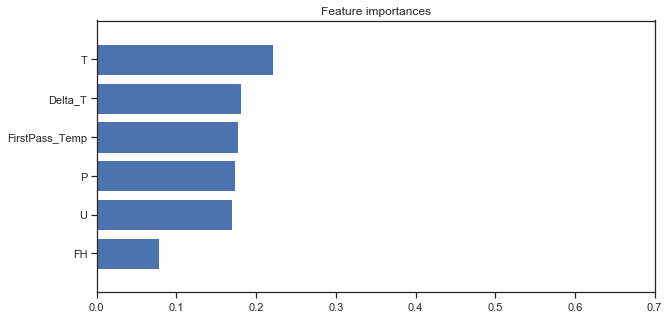

In [13]:
# importances = best_xgb_model.feature_importances_
# indices = np.argsort(importances)
# f, ax = plt.subplots(figsize=(10,5))
# plt.title("Feature importances")
# plt.barh(range(X.shape[1]), importances[indices], align="center")
# plt.yticks(range(X.shape[1]), X.columns.values[indices])
# plt.ylim([-1, X.shape[1]])
# plt.xlim([0,.7])
# plt.show()

In [72]:
MAE_XGBoost=pd.DataFrame(MAE_buf,columns=['XGboost'])
MAE_XGBoost.to_csv('XGBoost.csv')